In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torchvision import models
from tpot import TPOTRegressor
from tpot import TPOTClassifier
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from torch.optim import Adam, SGD
from qhoptim.pyt import QHM, QHAdam
from torch.optim import Adam, SGD
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import OneClassSVM, SVC
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood, SoftmaxLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
from RAdam.radam import RAdam
from torch.optim.lr_scheduler import StepLR

In [5]:
from flp.focalloss import FocalLoss

In [6]:
np.random.seed(1489)
torch.manual_seed(1489)
torch.cuda.manual_seed(1489)

In [7]:
TRAINED = "/home/bakirillov/HDD/weights/CRISPR-CAD/off-target/Peng_hitnet"
PENGPATH = "/home/bakirillov/HDD/data/CRISPR-CAD/Peng_offtargets/bty558-suppl_data/"
HPATH = "/home/bakirillov/HDD/data/CRISPR-CAD/Haeussler/13059_2016_1012_MOESM2_ESM.tsv"
LOW = op.join(PENGPATH, "Supplementary file 1.xlsx")
HIGH = op.join(PENGPATH, "Supplementary file 1.xlsx")
NEG = op.join(PENGPATH, "Supplementary file 1.xlsx")
CSPATH = "/home/bakirillov/HDD/data/CRISPR-CAD/CIRCLE-SEQ/nmeth.4278-S2.xlsx"
CSPATH2 = "/home/bakirillov/HDD/data/CRISPR-CAD/CIRCLE-SEQ/nmeth.4278-S3.xlsx"
SSPATH = "/home/bakirillov/HDD/data/CRISPR-CAD/SITE-SEQ/nmeth.4284-S2.xlsx"

In [8]:
UNDERSAMPLE = False

In [9]:
low = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=0)
high = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=1)
neg = pd.read_excel(op.join(PENGPATH, "Supplementary file 1.xlsx"), sheet_name=2)
low_strs = [a+","+b for a,b in zip(low["on-target site"], low["off-target site"])]
high_strs = [a+","+b for a,b in zip(high["on-target site"], high["off-target site"])]
neg_strs = [a+","+b for a,b in zip(neg["on-target site"], neg["no editing site"])]
low_high = list(set(low_strs+high_strs))
final_neg = []

In [10]:
if UNDERSAMPLE:
    for a in tqdm(low_high):
        suitable = list(
            filter(
                lambda x: x.split(",")[0] == a.split(",")[0] and x.split(",")[0] not in final_neg, 
                neg_strs
            )
        )
        final_neg.append(np.random.choice(suitable))
    final_neg = list(set(final_neg))
else:
    final_neg = neg_strs
pairs = np.array(low_high+final_neg)
labels = np.array([1]*len(low_high)+[0]*len(final_neg))

In [11]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([408260,    742]))

In [12]:
742/(408260+742)

0.001814172057838348

In [13]:
N_MISMATCHES = 6

In [14]:
if N_MISMATCHES != -1:
    n_mms = lambda x,y: np.sum([int(a != b) for a,b in zip(x,y)])
    worthy = np.array([n_mms(*a.split(",")) for a in pairs]) < N_MISMATCHES
    not_worthy = np.array([n_mms(*a.split(",")) for a in pairs]) > N_MISMATCHES
    pretraining_pairs = pairs[not_worthy]
    pretraining_labels = labels[not_worthy]
    pairs = pairs[worthy]
    labels = labels[worthy]

In [15]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([26038,   615]))

In [16]:
615/(615+26038)

0.02307432559186583

In [17]:
u = ImperfectMatchTransform("NGG", False, False, fold=False)

In [18]:
transformer = transforms.Compose(
    [
        u, ToTensor(True)
    ]
)

In [19]:
tt_X, val_X, tt_Y, val_Y = train_test_split(
    np.arange(len(pairs)), labels, test_size=0.1, stratify=labels
)

In [20]:
train_X, test_X, train_Y, test_Y = train_test_split(
    tt_X, tt_Y, stratify=tt_Y
)

In [21]:
train_X.shape, test_X.shape, val_X.shape

((17990,), (5997,), (2666,))

In [22]:
BATCH_SIZE=256

In [23]:
prt = np.random.choice(np.arange(pretraining_labels.shape[0]), size=2000)

In [24]:
np.unique(pretraining_labels[prt])

array([0])

### LOGO cv

In [25]:
guides = np.unique([a.split(",")[0] for a in low_high])

In [26]:
guides[0]

'AAATGAGAAGAAGAGGCACAGGG'

In [27]:
balaccs = {a:[] for a in guides}
aurocs = {a:[] for a in guides}
nb_balaccs = {a:[] for a in guides}
nb_aurocs = {a:[] for a in guides}
dm_balaccs = {a:[] for a in guides}
dm_aurocs = {a: [] for a in guides}
mv_balaccs = {a:[] for a in guides}
mv_aurocs = {a: [] for a in guides}
gp_balaccs = {a:[] for a in guides}
gp_aurocs = {a: [] for a in guides}
bg_balaccs = {a:[] for a in guides}
bg_aurocs = {a: [] for a in guides}
st_balaccs = {a:[] for a in guides}
st_aurocs = {a: [] for a in guides}
sp_balaccs = {a:[] for a in guides}
sp_aurocs = {a: [] for a in guides}

In [28]:
FE = 10
BATCH_SIZE = 512

In [29]:
THRESHOLD = 0.68

In [30]:
from xgboost import XGBClassifier

In [31]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [32]:
def get_leave_one_guide(guide, pairs, in_p = False):
    f1 = lambda x: guide in x
    f2 = lambda x: guide not in x
    r = list(filter(f1, pairs)) if in_p else list(filter(f2, pairs))
    return(r)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
guides = np.unique([a.split(",")[0] for a in low_high])

In [35]:
with open("training_stuff.bin", "rb") as ih:
    logo_set = pkl.load(ih)

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [37]:
PRETRAINED_MODEL = "Weissman.ptch"

In [38]:
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
from sklearn.svm import SVC

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [43]:
training_loss = {}
for i,a in enumerate(guides):
    print(i, a, len(guides))
    print("Making training set")
    encoder = GuideHN2d(
        23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
    ).cuda()
    model = DKL(encoder, [1,5*32]).cuda().eval()
    model.load_state_dict(torch.load(PRETRAINED_MODEL))
    model.eval()
    current_pairs = logo_set[a]["training"][0]
    current_labels = logo_set[a]["training"][1]
    print("Pairs in training set", len(current_pairs))
    print("Labels in training set", np.unique(current_labels, return_counts=True))
    X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(
        np.arange(len(current_pairs)), current_labels, stratify=current_labels
    )
    print(X_sample_test.shape)
    fold = PengDataset(
        current_pairs, current_labels, X_sample_test,
        transform=transformer
    )
    fold_loader = DataLoader(fold, shuffle=True, batch_size=BATCH_SIZE)
    print("Training of capsule network", len(current_pairs)/BATCH_SIZE)
    training_set = []
    training_targets = []
    for i,b in enumerate(fold_loader):
        sequence, target = b
        training_targets.append(target.cpu().data.numpy())
        output = model(sequence)[0]
        likelihood = model.likelihood(output)
        prediction = likelihood.mean.mean(0).cpu().data.numpy()
        upper = likelihood.confidence_region()[0].mean(0).cpu().data.numpy()
        variance = ((upper-prediction)/2)**2
        training_set.append([prediction, variance])
    training_set = np.concatenate(training_set, 1).T
    training_targets = np.concatenate(training_targets)
    estimators = [
        ("lr", LogisticRegression(C=0.1, dual=False, penalty="l1")), 
        ("dt", DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_leaf=17, min_samples_split=6)),
        ("dt2", DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=13, min_samples_split=15)),
        ("bnb", BernoulliNB(alpha=0.1, fit_prior=False)),
        ("pp", make_pipeline(
                make_union(
                    FunctionTransformer(copy),
                    FunctionTransformer(copy)
                ),
                KNeighborsClassifier(n_neighbors=71, p=1, weights="uniform")
            )
        )
    ]
    classifier = VotingClassifier(estimators, voting="soft")
    #classifier = DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_leaf=17, min_samples_split=6)
    #classifier = LogisticRegression(C=0.1, dual=False, penalty="l1")
    #classifier = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=13, min_samples_split=15)
    #classifier = TPOTClassifier(population_size=20, generations=10, config_dict="TPOT light")
    #classifier = LogisticRegression(solver="lbfgs", multi_class="auto", class_weight=(0.02,0.98))#VotingClassifier(estimators, voting="soft")
    #classifier = AdaBoostClassifier(base_estimator=LogisticRegression())#BaggingClassifier()#GaussianProcessClassifier()#GaussianNB()#LogisticRegression(solver="lbfgs", multi_class="auto")
    classifier.fit(training_set, training_targets.reshape(-1,1))
    current_pairs_t = logo_set[a]["testing"][0]
    current_labels_t = logo_set[a]["testing"][1]
    test_fold = PengDataset(
        current_pairs_t, current_labels_t, np.arange(len(current_pairs_t)),
        transform=transformer
    )
    test_fold_loader = DataLoader(test_fold, shuffle=True, batch_size=256)
    print("Testing", len(current_pairs_t)/256)
    testing_set = []
    testing_targets = []
    for sequence, target in tqdm(test_fold_loader):
        sequence, target = b
        testing_targets.append(target.cpu().data.numpy())
        output = model(sequence)[0]
        likelihood = model.likelihood(output)
        prediction = likelihood.mean.mean(0).cpu().data.numpy()
        upper = likelihood.confidence_region()[0].mean(0).cpu().data.numpy()
        variance = ((upper-prediction)/2)**2
        testing_set.append([prediction, variance])
    testing_set = np.concatenate(testing_set, 1).T
    testing_targets = np.concatenate(testing_targets)
    testing_predictions = classifier.predict(testing_set)
    balaccs[a].append(
        balanced_accuracy_score(testing_targets, testing_predictions)
    )
    #classifier.export("tpot_hom_pipeline_"+a+".py")
    print(
        "balaccs", balaccs[a]
    )
    del encoder
    torch.cuda.empty_cache()

0 AAATGAGAAGAAGAGGCACAGGG 29
Making training set
Pairs in training set 26640
Labels in training set (array([0, 1]), array([26038,   602]))
(6660,)
Training of capsule network 52.03125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 144.20703125


100%|██████████| 145/145 [00:04<00:00, 33.29it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
1 AACACCAGTGAGTAGAGCGGAGG 29
Making training set
Pairs in training set 26647
Labels in training set (array([0, 1]), array([26038,   609]))
(6662,)
Training of capsule network 52.044921875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 31.71875


100%|██████████| 32/32 [00:01<00:00, 30.88it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
2 AATGACCACTACATCCTCAAGGG 29
Making training set
Pairs in training set 26648
Labels in training set (array([0, 1]), array([26038,   610]))
(6662,)
Training of capsule network 52.046875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 34.4296875


100%|██████████| 35/35 [00:01<00:00, 33.77it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [0.5]
3 ATGAACACCAGTGAGTAGAGCGG 29
Making training set
Pairs in training set 26641
Labels in training set (array([0, 1]), array([26038,   603]))
(6661,)
Training of capsule network 52.033203125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 47.7421875


100%|██████████| 48/48 [00:01<00:00, 33.23it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
4 CCAGTGAGTAGAGCGGAGGCAGG 29
Making training set
Pairs in training set 26642
Labels in training set (array([0, 1]), array([26038,   604]))
(6661,)
Training of capsule network 52.03515625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 52.2265625


100%|██████████| 53/53 [00:01<00:00, 33.05it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
5 CCCTGTGTCTCTGGATGGATGGG 29
Making training set
Pairs in training set 26652
Labels in training set (array([0, 1]), array([26038,   614]))
(6663,)
Training of capsule network 52.0546875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 45.87109375


100%|██████████| 46/46 [00:01<00:00, 31.27it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
6 CCTGCCTCCGCTCTACTCACTGG 29
Making training set
Pairs in training set 26642
Labels in training set (array([0, 1]), array([26038,   604]))
(6661,)
Training of capsule network 52.03515625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 42.62109375


100%|██████████| 43/43 [00:01<00:00, 28.40it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
7 CTTGCCCCACAGGGCAGTAACGG 29
Making training set
Pairs in training set 26649
Labels in training set (array([0, 1]), array([26038,   611]))
(6663,)
Training of capsule network 52.048828125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 33.85546875


100%|██████████| 34/34 [00:01<00:00, 32.26it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
8 GAACACAAAGCATAGACTGCGGG 29
Making training set
Pairs in training set 26638
Labels in training set (array([0, 1]), array([26038,   600]))
(6660,)
Training of capsule network 52.02734375


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 45.98046875


100%|██████████| 46/46 [00:01<00:00, 32.40it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
9 GAATCCTAAAAACTCTGCTTCGG 29
Making training set
Pairs in training set 26640
Labels in training set (array([0, 1]), array([26038,   602]))
(6660,)
Training of capsule network 52.03125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 44.640625


100%|██████████| 45/45 [00:01<00:00, 31.91it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
10 GACACCGAAGCAGAGTTTTTAGG 29
Making training set
Pairs in training set 26644
Labels in training set (array([0, 1]), array([26038,   606]))
(6661,)
Training of capsule network 52.0390625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 30.86328125


100%|██████████| 31/31 [00:01<00:00, 29.72it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
11 GACATCGATGTCCTCCCCATTGG 29
Making training set
Pairs in training set 26648
Labels in training set (array([0, 1]), array([26038,   610]))
(6662,)
Training of capsule network 52.046875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 18.734375


100%|██████████| 19/19 [00:00<00:00, 29.62it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
12 GACCCCCTCCACCCCGCCTCCGG 29
Making training set
Pairs in training set 26568
Labels in training set (array([0, 1]), array([26038,   530]))
(6642,)
Training of capsule network 51.890625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 68.0703125


100%|██████████| 69/69 [00:02<00:00, 25.15it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [0.5]
13 GAGTCCGAGCAGAAGAAGAAGGG 29
Making training set
Pairs in training set 26586
Labels in training set (array([0, 1]), array([26038,   548]))
(6647,)
Training of capsule network 51.92578125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 61.85546875


100%|██████████| 62/62 [00:02<00:00, 24.87it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [0.5]
14 GCCTCCCCAAAGCCTGGCCAGGG 29
Making training set
Pairs in training set 26642
Labels in training set (array([0, 1]), array([26038,   604]))
(6661,)
Training of capsule network 52.03515625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 57.91015625


100%|██████████| 58/58 [00:01<00:00, 31.76it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
15 GCGCCACCGGTTGATGTGATGGG 29
Making training set
Pairs in training set 26652
Labels in training set (array([0, 1]), array([26038,   614]))
(6663,)
Training of capsule network 52.0546875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 9.87890625


100%|██████████| 10/10 [00:00<00:00, 32.96it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
16 GGAATCCCTTCTGCAGCACCTGG 29
Making training set
Pairs in training set 26631
Labels in training set (array([0, 1]), array([26038,   593]))
(6658,)
Training of capsule network 52.013671875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 40.0


100%|██████████| 40/40 [00:01<00:00, 30.85it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
17 GGCACTGCGGCTGGAGGTGGGGG 29
Making training set
Pairs in training set 26518
Labels in training set (array([0, 1]), array([26038,   480]))
(6630,)
Training of capsule network 51.79296875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 117.87109375


100%|██████████| 118/118 [00:04<00:00, 24.75it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [0.5]
18 GGCCAGGCTTTGGGGAGGCCTGG 29
Making training set
Pairs in training set 26645
Labels in training set (array([0, 1]), array([26038,   607]))
(6662,)
Training of capsule network 52.041015625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 89.58203125


100%|██████████| 90/90 [00:02<00:00, 33.74it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
19 GGCCCAGACTGAGCACGTGATGG 29
Making training set
Pairs in training set 26646
Labels in training set (array([0, 1]), array([26038,   608]))
(6662,)
Training of capsule network 52.04296875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 32.35546875


100%|██████████| 33/33 [00:01<00:00, 32.78it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
20 GGGAAAGACCCAGCATCCGTGGG 29
Making training set
Pairs in training set 26642
Labels in training set (array([0, 1]), array([26038,   604]))
(6661,)
Training of capsule network 52.03515625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 26.36328125


100%|██████████| 27/27 [00:00<00:00, 32.84it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
21 GGGTGGGGGGAGTTTGCTCCAGG 29
Making training set
Pairs in training set 26631
Labels in training set (array([0, 1]), array([26038,   593]))
(6658,)
Training of capsule network 52.013671875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 59.1484375


100%|██████████| 60/60 [00:01<00:00, 34.19it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
22 GGGTGGGGGGAGTTTGCTCCTGG 29
Making training set
Pairs in training set 26628
Labels in training set (array([0, 1]), array([26038,   590]))
(6657,)
Training of capsule network 52.0078125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 59.15625


100%|██████████| 60/60 [00:01<00:00, 30.42it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
23 GGTCCTGCCGCTGCTTGTCATGG 29
Making training set
Pairs in training set 26640
Labels in training set (array([0, 1]), array([26038,   602]))
(6660,)
Training of capsule network 52.03125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 34.0


100%|██████████| 34/34 [00:01<00:00, 30.53it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
24 GGTGAGTGAGTGTGTGCGTGTGG 29
Making training set
Pairs in training set 26587
Labels in training set (array([0, 1]), array([26038,   549]))
(6647,)
Training of capsule network 51.927734375


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 130.578125


100%|██████████| 131/131 [00:05<00:00, 24.12it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [0.5]
25 GTCACCTCCAATGACTAGGGTGG 29
Making training set
Pairs in training set 26645
Labels in training set (array([0, 1]), array([26038,   607]))
(6662,)
Training of capsule network 52.041015625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 24.03515625


100%|██████████| 25/25 [00:00<00:00, 34.83it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
26 GTCATCTTAGTCATTACCTGAGG 29
Making training set
Pairs in training set 26648
Labels in training set (array([0, 1]), array([26038,   610]))
(6662,)
Training of capsule network 52.046875


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 31.44140625


100%|██████████| 32/32 [00:00<00:00, 32.10it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
27 TGACATCAATTATTATACATCGG 29
Making training set
Pairs in training set 26640
Labels in training set (array([0, 1]), array([26038,   602]))
(6660,)
Training of capsule network 52.03125


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 58.7421875


100%|██████████| 59/59 [00:01<00:00, 32.00it/s]
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


balaccs [1.0]
28 TGGATGGAGGAATGAGGAGTTGG 29
Making training set
Pairs in training set 26642
Labels in training set (array([0, 1]), array([26038,   604]))
(6661,)
Training of capsule network 52.03515625


/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=Fa

Testing 123.78515625


100%|██████████| 124/124 [00:03<00:00, 32.28it/s]

balaccs [1.0]



/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [44]:
np.mean([balaccs[a][-1] for a in balaccs])

0.9137931034482759

In [46]:
np.std([balaccs[a][-1] for a in balaccs])

0.1888698474155745

In [45]:
len(guides)

29

In [48]:
goods=[
    "AAATGAGAAGAAGAGGCACAGGG",
    "AACACCAGTGAGTAGAGCGGAGG",
    "ATGAACACCAGTGAGTAGAGCGG",
    "CCAGTGAGTAGAGCGGAGGCAGG",
    "CCCTGTGTCTCTGGATGGATGGG",
    "CCTGCCTCCGCTCTACTCACTGG",
    "CTTGCCCCACAGGGCAGTAACGG",
    "GAACACAAAGCATAGACTGCGGG",
    "GAATCCTAAAAACTCTGCTTCGG",
    "GACACCGAAGCAGAGTTTTTAGG",
    "GACATCGATGTCCTCCCCATTGG",
    "GCCTCCCCAAAGCCTGGCCAGGG",
    "GCGCCACCGGTTGATGTGATGGG",
    "GGAATCCCTTCTGCAGCACCTGG",
    "GGCCAGGCTTTGGGGAGGCCTGG",
    "GGCCCAGACTGAGCACGTGATGG",
    "GGGAAAGACCCAGCATCCGTGGG",
    "GGGTGGGGGGAGTTTGCTCCAGG",
    "GGGTGGGGGGAGTTTGCTCCTGG",
    "GGTCCTGCCGCTGCTTGTCATGG",
    "GTCACCTCCAATGACTAGGGTGG",
    "GTCATCTTAGTCATTACCTGAGG",
    "TGACATCAATTATTATACATCGG",
    "TGGATGGAGGAATGAGGAGTTGG"
]

In [49]:
bads = [
    "GACCCCCTCCACCCCGCCTCCGG",
    "AATGACCACTACATCCTCAAGGG",
    "GAGTCCGAGCAGAAGAAGAAGGG",
    "GGCACTGCGGCTGGAGGTGGGGG",
    "GGTGAGTGAGTGTGTGCGTGTGG"
]

In [54]:
import editdistance

In [57]:
ed = np.zeros(shape=(29,29))
for i,a in tqdm(enumerate(goods+bads)):
    for j,b in tqdm(enumerate(goods+bads)):
        ed[i,j] = editdistance.eval(a, b)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
29it [00:00, 31750.15it/s]
0it [00:00, ?it/s]
29it [00:00, 37751.34it/s]
0it [00:00, ?it/s]
29it [00:00, 29929.83it/s]
0it [00:00, ?it/s]
29it [00:00, 42425.82it/s]
0it [00:00, ?it/s]
29it [00:00, 41471.13it/s]
0it [00:00, ?it/s]
29it [00:00, 43612.34it/s]
0it [00:00, ?it/s]
29it [00:00, 59046.03it/s]
0it [00:00, ?it/s]
29it [00:00, 60274.93it/s]
0it [00:00, ?it/s]
29it [00:00, 72748.10it/s]
0it [00:00, ?it/s]
29it [00:00, 88784.54it/s]
0it [00:00, ?it/s]
29it [00:00, 79551.87it/s]
0it [00:00, ?it/s]
29it [00:00, 82970.54it/s]
0it [00:00, ?it/s]
29it [00:00, 65080.16it/s]
0it [00:00, ?it/s]
29it [00:00, 65926.73it/s]
0it [00:00, ?it/s]
29it [00:00, 80606.24it/s]
0it [00:00, ?it/s]
29it [00:00, 77425.09it/s]
0it [00:00, ?it/s]
29it [00:00, 78830.08it/s]
0it [00:00, ?it/s]
29it [00:00, 60007.31it/s]
0it [00:00, ?it/s]
29it [00:00, 66034.10it/s]
0it [00:00, ?it/s]
29it [00:00, 75315.68it/s]
0it [00:00, ?it/s]
29it [00:00, 65395.06it/s]
0it [00:00, ?it

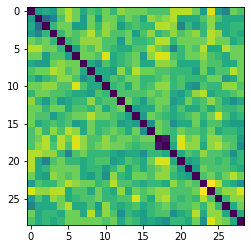

In [59]:
plt.imshow(ed)

In [71]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram

In [74]:
l = linkage(ssd.squareform(ed), method="ward")

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [125.0, 125.0, 135.0, 135.0],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [130.0, 130.0, 152.5, 152.5],
  [102.5, 102.5, 141.25, 141.25],
  [61.25, 61.25, 121.875, 121.875],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [205.0, 205.0, 215.0, 215.0],
  [182.5, 182.5, 210.0, 210.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [260.0, 260.0, 280.0, 280.0],
  [232.5, 232.5, 270.0, 270.0],
  [196.25, 196.25, 251.25, 251.25],
  [91.5625, 91.5625, 223.75, 223.75],
  [20.0, 20.0, 157.65625, 157.65625]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 9.0, 9.0, 0.0],
  [1.0, 13.490737563232042, 13.49073756323204

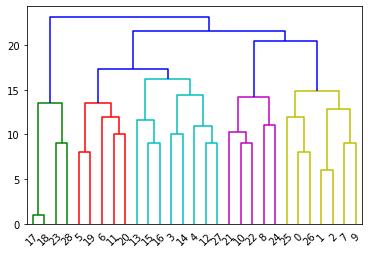

In [75]:
dendrogram(l)